In [2]:
import pandas as pd
import seaborn as sns
from datetime import datetime, date
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [1]:
def drop_useless_cols(df, drop_values = []):
    continuous_columns = ['amount_tsh', 'date_recorded', 'gps_height', 'population', 'construction_year']
    for cont in continuous_columns:
        if cont in drop_values:
            print(f'you cannot drop column: {cont}')
            return
        
    try:
        df_dropped = df.drop(drop_values, axis = 1)
        return df_dropped
    except:
        return df
    
def load_data(string1, string2):
    """
        pass in two strings containg csv info, this function will load the two dataframes and merge them along the column 'id'
    """
    df_1 = pd.read_csv(string1)
    df_2 = pd.read_csv(string2)
    #merging dataframes
    df = pd.merge(df_1, df_2, on = 'id', how = 'inner')
    return df

    
def fix_dates(df):
    """ will take the date of 01/01/2020 and subtract it from the 'date_recorded' column.
        This information will be stored in column called 'days_since_recording'
        This will also drop the 'date_recorded' column
    """
    basedate = datetime(2020, 1, 1)
    df['days_since_recording'] = df.loc[:,'date_recorded'].map(lambda x: (basedate - datetime.strptime(x, "%Y-%m-%d")).days)
    df.drop(['date_recorded'], axis = 1, inplace = True)
    return df

def clean_data(df, threshold = 100):
    # replaces NaN with a string 'not known'
    df = df.fillna('Not Known')
    
    uvdict = {}

    for column in df.select_dtypes(exclude=['int','float']):
        values_list = df[column].unique()
        uvdict[column] = len(values_list)

    target_list = list(filter(lambda x: uvdict[x] > threshold, uvdict.keys()))
                       
                       
    for col in target_list:
        valued_dict = dict(df[col].value_counts())
        safe_values = list(key for key, value in valued_dict.items() if value >= 50)
    #     replace_values = list(filter(lambda x: x not in safe_values, all_values))
        df.loc[:, col] = df.loc[:, col].map(lambda y: 'other' if y not in safe_values else y)
    
    
    return df

def bin_me(df):
    """
        creates bins for construction_year based on 5 year increments
        inaddition, values stored as year 0 will be transformed to not_available
    """
    try:
        basedate = datetime(2020, 1, 1)
        a = list(range(1955,2016,5))
        cut_bins = [-1]
        cut_bins.extend(a)
        cut_labels = ['not available', '56-60','61-65','66-70','71-75','76-80','81-85','86-90','91-95','96-00','01-05','06-10','11-15']
        df.loc[:, 'construction_year_bin'] = pd.cut(df['construction_year'], bins = cut_bins, labels = cut_labels)
        df.drop(['construction_year'], axis = 1, inplace = True)
        return df
    except:
        if 'construction_year_bin' in df.columns:
            print('action already performed')
        else:
            print('you messed up')

def onehotmess(df):
    df_objects = df.select_dtypes(exclude=['int','float']).drop(['status_group'], axis = 1)
    df_nums = df.select_dtypes(include=['int','float'])

    df_onehot = pd.get_dummies(df_objects)

    df_final = pd.concat([df_nums, df_onehot], axis = 1)
    
    return df_final, df.status_group

def normalize_func(df_values, df_target):
    X_train, X_test, y_train, y_test = train_test_split(df_values, df_target, test_size = .05, random_state = 42)
    scaler = MinMaxScaler()
    
    X_train_ = scaler.fit_transform(X_train)
    X_test_ = scaler.transform(X_test)
    
    return X_train_, X_test_, y_train, y_test


def do_everything(string1, string2, drop_values, thresh = 200):
    """this funciton is magical and does everything we could ever want and more"""
    loaded_data = load_data(string1, string2)
    df_dropped = drop_useless_cols(loaded_data, drop_values)
    fixed_date = fix_dates(df_dropped)
    cleaner_df = clean_data(fixed_date, thresh)
    df_binned = bin_me(cleaner_df)
    ohm_df, target_df = onehotmess(df_binned)
    X_train, X_test, y_train, y_test = normalize_func(ohm_df, target_df)
    
    return X_train, X_test, y_train, y_test, ohm_df, target_df

In [3]:
string_1 = './data/training_data_values.csv' 
string_2 = './data/training_data_labels.csv'
drop_columns = ['id', 'funder', 'num_private', 'longitude', 'latitude', 'wpt_name', 'subvillage', 'region_code', 'lga',
                'ward','recorded_by', 'scheme_name', 'extraction_type_group', 'payment', 'quality_group', 
                'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']


X_train, X_test, y_train, y_test, df_values, df_target = do_everything(string_1, string_2, drop_columns)

In [4]:
GBR = GradientBoostingClassifier(n_estimators = 200)
GBR.fit(X_train, y_train)
gbr_weight = GBR.score(X_test, y_test)

In [6]:
LR = LogisticRegression(random_state = 0, max_iter = 1000)
LR.fit(X_train, y_train)
lr_weight = LR.score(X_test, y_test)

In [9]:
RF = RandomForestClassifier(n_estimators = 200, random_state = 7)
RF.fit(X_train, y_train)
rf_weight = RF.score(X_test, y_test)

In [10]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_weight = knn.score(X_test, y_test)

In [11]:
RF1 = RandomForestClassifier(n_estimators = 200)
LR1 = LogisticRegression(max_iter = 1000)
GBR1 = GradientBoostingClassifier(n_estimators = 300)
KNN1 = KNeighborsClassifier()

In [12]:
eclf_soft = VotingClassifier(estimators = [('lr', LR1), ('rf', RF1), ('gbr', GBR1), ('knn', KNN1)], 
                             weights = [lr_weight, rf_weight, gbr_weight, knn_weight], 
                             voting = 'soft')
eclf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                            

In [14]:
svc_accuracy = round(eclf_soft.score(X_test, y_test), 2)

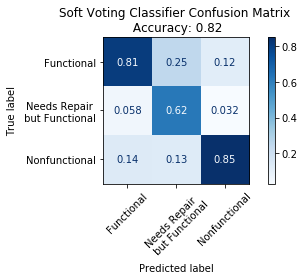

In [15]:
plot_confusion_matrix(eclf_soft, X_test, y_test, xticks_rotation=45, display_labels = ['Functional', 'Needs Repair \n but Functional', 'Nonfunctional'], 
                     normalize='pred', cmap='Blues')
plt.title(f'Soft Voting Classifier Confusion Matrix \n Accuracy: {svc_accuracy}')
plt.tight_layout()
plt.savefig('Voting_classifier_confusion_matrix.png', dpi = 300, transparent = True, );